In [69]:
import pandas as pd
import pymysql
db_info = pymysql.connect(user='root', passwd='root',host='localhost',port=3306, db='test')
cursor = db_info.cursor()

In [5]:
sql = "SELECT * FROM review;"
cursor.execute(sql)
result = pd.DataFrame(cursor.fetchall())

In [6]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82522 entries, 0 to 82521
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   0       82522 non-null  int64         
 1   1       82522 non-null  int64         
 2   2       82522 non-null  object        
 3   3       82522 non-null  datetime64[ns]
 4   4       82522 non-null  int64         
 5   5       82522 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 3.8+ MB


In [65]:
def user_log_data():
    cursor.execute("SELECT * FROM user_log")

    result = []
    for c in cursor:
        res = dict()
        res['reg_time'] = c[1]
        res['user_id'] = c[2]
        res['book_id'] = c[3]
        result.append(res)
    return pd.DataFrame(result).sort_values(by='reg_time',ascending=False).drop_duplicates(['user_id','book_id'],keep='first').reset_index(drop=True)


def book_data():
    cursor.execute("SELECT * FROM book")

    result = []
    for c in cursor:
        res = dict()
        res['book_id'] = c[0]
        res['category_id'] = c[4]
        result.append(res)

    return pd.DataFrame(result)


def user_category_data():
    cursor.execute("SELECT * FROM user_category")

    result = []
    for c in cursor:
        res = dict()
        res['user_id'] = c[1]
        res['user_category_id'] = c[2]
        result.append(res)

    return pd.DataFrame(result)


def review_data():
    cursor.execute("SELECT * FROM review")

    result = []
    for c in cursor:
        res = dict()
        res['book_id'] = c[5]
        res['user_id'] = c[4]
        res['rank'] = c[1]
        res['reg_time'] = c[3]
        res['content'] = c[2]
        result.append(res)

    return pd.DataFrame(result).sort_values(by='reg_time',ascending=False).drop_duplicates(['user_id','book_id'],keep='first').reset_index(drop=True)

In [140]:
user_log = user_log_data()
user_category = user_category_data()
book = book_data()
review = review_data()

In [141]:
data1 = pd.merge(user_log[["book_id","user_id"]], review, how="left", on=["book_id","user_id"])
data1['content'].fillna('',inplace=True)

data1['content'] = data1['content'].str.replace(pat=r'[^A-Za-z0-9가-힣 ]', repl= r'', regex=True).str.strip()
data1['rank'].fillna(int(data1['rank'].mean()),inplace=True)
data1 = pd.merge(data1, book, on="book_id")
data1

,book_id,user_id,rank,reg_time,content,category_id
0,28871,18206,10,2021-09-30,미워도 다시한번,112011
1,28871,40752,10,2021-09-29,나가토 유키는 인기투표 1위를 했다나가토가 가장 인기가 많은 것이다NYUKI,112011
2,28871,10,10,2021-09-28,전설이 돌아왔다 4년만에 신작냈다고 욕먹더니 삐져서 9년만에 결국 한국 기준으로는 ...,112011
3,28871,40747,10,2021-09-28,하루히 다음 권이 나오길 약 9년을 기다리는 사이 난 학생에서 라이트노벨 작가로 데...,112011
4,28871,40751,10,2021-09-28,너희들 스즈미야 하루히를 잊어버린거야,112011
...,...,...,...,...,...,...
72964,19689,35670,10,2019-01-01,믿고 보는 미스테리아 이번 달력도 잘 사용할게요,2913
72965,12790,28596,6,2019-01-01,우드카빙에 대한 기술적인 부분은 끝에 살짝나오구요 실질적으로는 에세이에 가깝습니다 ...,1230
72966,9563,24625,10,2019-01-01,아이가 책이 오자마자 다읽고 또 읽고그러구선 다음책 기다립니다다음책 기다리기 목빠져유,1108
72967,29465,43310,8,2019-01-01,12권까지는 진짜 숨막히게 다음장엔 무슨 내용이 나올까 하면서 읽었는데 3권은 좀 ...,112011


In [142]:
def cate_coding(x):
    for cate in x['user_category_id']:
        x['c_'+str(cate)] = 1
    return x

user_category['user_category_id'] = user_category['user_category_id'].astype(str)
user_cate = user_category.groupby('user_id').agg(lambda x: ' '.join(set(x)))
user_cate['user_category_id'] = user_cate['user_category_id'].str.split(' ')


cate_list = book['category_id'].unique()
for cate in cate_list:
    user_cate['c_' + str(cate)] = 0

user_cate = user_cate.apply(cate_coding,axis=1)

user_pre_cate = user_cate.drop('user_category_id',axis=1)

user_see_cate = data1.pivot_table(values='rank',index='user_id',columns='category_id').fillna(0)

In [143]:
user_cate = pd.concat([user_pre_cate, user_see_cate],axis=1).fillna(0)
user_cate

,c_1,c_74,c_170,c_336,c_351,c_517,c_656,c_798,c_987,c_1108,...,4395,8257,13789,17195,50246,55889,55890,76000,76001,112011
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,0,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,10.0
2,1,1,0,0,0,0,1,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,1,0,0,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,10.0
5,1,1,0,0,0,1,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45218,1,1,0,0,0,0,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45219,1,1,0,0,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45220,1,1,0,0,0,0,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [151]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

stopword= ' '.join([line.rstrip('\n') for line in open('stopwords-ko.txt', 'r',encoding="utf-8")])

tfidf = TfidfVectorizer(stop_words='english',max_features=300)

tfidf_matrix = tfidf.fit_transform(data1['content'])

In [163]:
tfidf_data = pd.DataFrame(tfidf_matrix.toarray(),index=data1['user_id']).reset_index()
tfidf_g_data = tfidf_data.groupby('user_id').mean()
user_cate_tf = pd.concat([user_cate, tfidf_g_data],axis=1).fillna(0)

In [188]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3,random_state=0)
pca.fit(user_cate_tf)
pca_samples = pca.transform(user_cate_tf)
ps = pd.DataFrame(pca_samples, index=user_cate_tf.index)

In [167]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
plt.style.use('ggplot')

In [173]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

scores = []

for i in range(2,8):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(ps)
    scores.append(silhouette_score(ps, kmeans.labels_))


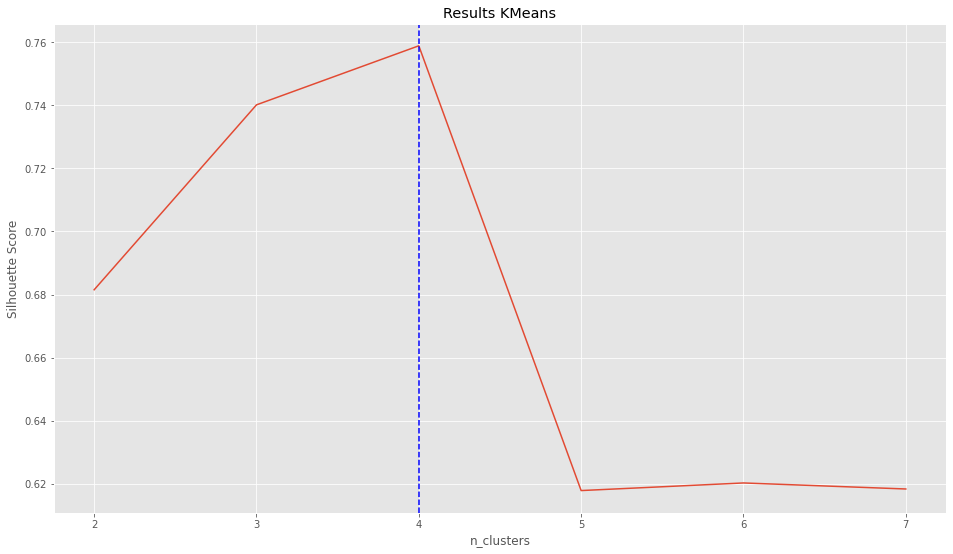

In [174]:
plt.plot(range(2,8), scores);
plt.title('Results KMeans')
plt.xlabel('n_clusters');
plt.axvline(x=4, color='blue', linestyle='--')
plt.ylabel('Silhouette Score');
plt.show()

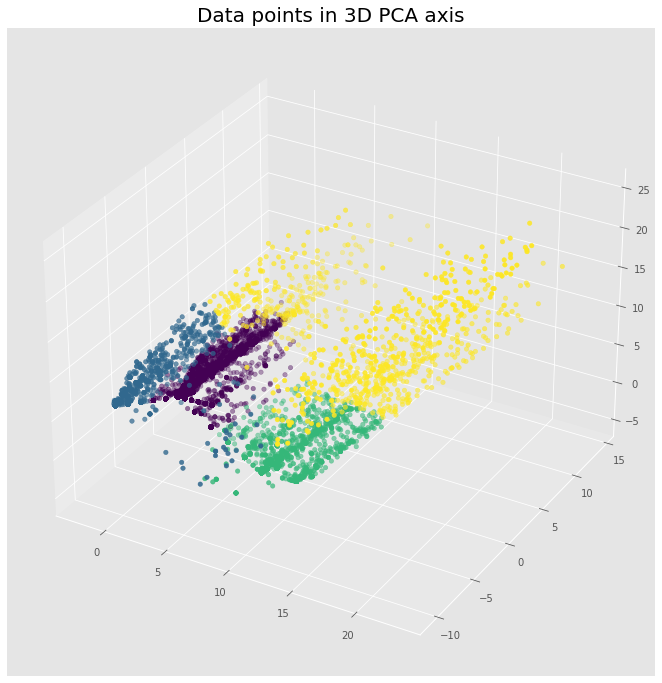

In [189]:
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(ps)

plt.rcParams['figure.figsize'] = (16, 9)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(ps[0], ps[2], ps[1], c=kmeans.labels_)

plt.title('Data points in 3D PCA axis', fontsize=20)
plt.show()

In [198]:
ps.loc[2:3,:]

,0,1,2
user_id,,,
2,6.721529,-4.874700,-2.588433
3,6.722556,-4.876743,-2.585794


In [208]:
pred = kmeans.predict(ps.loc[1,:].to_frame().T)
user_cate_tf['cluster'] = kmeans.labels_
user_cate_tf_cluster = user_cate_tf[user_cate_tf['cluster']==pred[0]]

In [209]:
user_cate_tf_cluster 

,c_1,c_74,c_170,c_336,c_351,c_517,c_656,c_798,c_987,c_1108,...,291,292,293,294,295,296,297,298,299,cluster
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,0,0,0,0,1,0,0,...,0.000000,0.000000,0.021644,0.006719,0.000000,0.000000,0.000000,0.000000,0.000000,3
5,1,1,0,0,0,1,1,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3
9,1,1,0,0,0,0,1,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3
10,1,1,0,0,0,0,1,1,1,0,...,0.006391,0.007440,0.008165,0.004649,0.003046,0.003247,0.002406,0.001289,0.002494,3
12,0,1,0,0,0,0,1,0,0,0,...,0.038174,0.011675,0.012477,0.000000,0.000000,0.000000,0.000000,0.000000,0.009861,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19895,1,1,0,0,0,0,0,1,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062398,0.000000,0.000000,3
19932,1,1,0,0,0,0,1,1,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3
20065,1,1,0,0,0,0,1,1,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3


In [210]:
user_cate_tf['cluster'].value_counts()

0    36048
2     4912
1     3293
3      969
Name: cluster, dtype: int64

In [68]:
cursor.close()

,1
c_1,0.0
c_74,1.0
c_170,0.0
c_336,0.0
c_351,0.0
c_517,0.0
c_656,0.0
c_798,1.0
c_987,0.0
c_1108,0.0
